# Demo de implementación de un algoritmo de Bandadas de Pájaros (Particle Swarm Optimization o PSO) para resolver el problema de encontrar un Máximo Óptimo definido al azar en un plano y tratando de esquivar los máximos locales aleatorios
El código es una adaptación del ejemplo de la librería DEAP disponible en https://deap.readthedocs.io/en/master/ pero no utiliza la librería (no son necesarios los operadores ni clases) y se mejora

1) Importar librerías:

In [1]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import operator
import copy
print("\nLibrerías importadas")


Librerías importadas


2) Establecer parámetros generales de la Corrida:

In [2]:
# Cantidad de Máximos Locales
CANT_MAXIMOS_LOCALES = 3

# Espacio mínimo y máximp del espacio de búsqueda
MIN_ESPACIO_BUSQ = -1000
MAX_ESPACIO_BUSQ = 1000

# Cantidad de Ciclos de la Corrida
CANT_CICLOS = 100

# Cantidad de Particulas
CANT_PARTICULAS = 10

# Indica si se muestra el detalle de cada ciclo
MUESTRA_DETALLE = True

print("\nParámetros de la Corrida definidos")


Parámetros de la Corrida definidos


3) Especificar el objeto Particula y la Función Heurística:

In [3]:
### FUNCIÓN HEURÍSTICA

# Define Posiciones Random para Máximos Locales y Óptimos
# con Heurística también al Azar (entre -10 y 100)
POS_RANDOM_EVALUAR = []
VAL_RANDOM_EVALUAR = []
POS_RANDOM_EVALUAR_OPTIMO = 0
auxMejorVal = -99
print("** Posiciones Generadas al Azar: **")
for i in range(CANT_MAXIMOS_LOCALES+1):

    auxPos = ( round(random.uniform(MIN_ESPACIO_BUSQ, MAX_ESPACIO_BUSQ),3),  round(random.uniform(MIN_ESPACIO_BUSQ, MAX_ESPACIO_BUSQ),3) ) 
    auxVal = int(random.uniform(-10, 100))

    POS_RANDOM_EVALUAR.append( auxPos )
    VAL_RANDOM_EVALUAR.append( auxVal )
    
    print(" -->", auxPos, "{ ", auxVal, "} ")

    if VAL_RANDOM_EVALUAR[POS_RANDOM_EVALUAR_OPTIMO] < auxVal:
        POS_RANDOM_EVALUAR_OPTIMO = i

print("** Posición Máximo Óptimo a Buscar: ", POS_RANDOM_EVALUAR[POS_RANDOM_EVALUAR_OPTIMO], " { ",  VAL_RANDOM_EVALUAR[POS_RANDOM_EVALUAR_OPTIMO]," } **")

# Definimos la función a evaluar
def funcHeuristica(particula):

    devuelve = -100
    disPosMenor = MAX_ESPACIO_BUSQ
    for posi, vali in zip(POS_RANDOM_EVALUAR, VAL_RANDOM_EVALUAR):

          # calcula la distancia al punto de la Particula
          sqerrors = ((x - y)**2 for x, y in zip(particula.posicion, posi))
          distPos =  math.fsum(sqerrors)**0.5 / 10
          
          # Si es la menor distancia calcula la Heurística
          if disPosMenor > distPos:
              disPosMenor = distPos 
              devuelve = ( vali - distPos) 

    return devuelve

print("\nFunción Heurística definida")

** Posiciones Generadas al Azar: **
 --> (-633.849, 484.755) {  95 } 
 --> (-484.718, 342.928) {  32 } 
 --> (683.0, 151.24) {  71 } 
 --> (-783.398, -569.031) {  29 } 
** Posición Máximo Óptimo a Buscar:  (-633.849, 484.755)  {  95  } **

Función Heurística definida


In [4]:
### clase PARTICULA

class Particula(object):
    
    def __init__(self, pmin, pmax):        
        self.pos = [random.uniform(pmin, pmax) for _ in range(2)]
        self.valor = funcHeuristica(self)
        self.velocidad = [random.uniform(pmin//10, pmax//10) for _ in range(len(self.pos))]
        self.limMin = pmin
        self.limMax = pmax

    def _reset(self):
        self.pos = []
        self.valor = -9999
        self.velocidad = []

    @property
    def heuristica(self):
        return self.valor

    @property
    def posicion(self):
        return self.pos   

    def moverse(self, mejorCiclo, mejorCorrida, coefAtraccMejorCiclo=1.5, coefAtraccMejorCorrida=3):
        for i in range(len(self.pos)):
              # calcula el desplazamiento (velocidad) en base a la atracción a la mejor del ciclo y global
            self.velocidad[i] = self.velocidad[i]  \
                                    + (coefAtraccMejorCiclo * random.uniform(0, 1) * (mejorCiclo.posicion[i]-self.pos[i])) \
                                    + (coefAtraccMejorCorrida * random.uniform(0, 1) * (mejorCorrida.posicion[i]-self.pos[i]))

              # ajusta la posición de la partícula (se ajusta la velocidad para que cambie de a poco)
            self.pos[i] = self.pos[i] + self.velocidad[i]

              # revisa no haber superado los límites del mapa
            if self.pos[i] < self.limMin:
                  self.pos[i] = self.limMin
            elif self.pos[i] > self.limMax:
                  self.pos[i] = self.limMax

          # actualiza su heurística
        self.valor = funcHeuristica(self)
        return copy.deepcopy( self.pos )

print("\nClase Particula definida")


Clase Particula definida


4) Ejecutar la corrida del algoritmo mostrando resultados:

In [5]:
## EJECUCIÓN DE LA CORRIDA

# vectores auxiliares 
ciclo = 1    
mejorPartCiclo = None
mejorPartCorrida = None
ciclosParticulas = []
ciclosMaxAptitud = []
ciclosMaxAptitud = []
partPobla = []

# Define la población de las Particulas
for i in range(CANT_PARTICULAS):
  p = Particula(pmin=MIN_ESPACIO_BUSQ, pmax=MAX_ESPACIO_BUSQ)
  partPobla.append( p ) 
  ciclosParticulas.append( p.posicion )

while (ciclo < CANT_CICLOS):

    if MUESTRA_DETALLE:
        print("\n-- Ciclo  %i --" % ciclo)        

    # Evalúa las particulas de la población para determinar las mejores 
    rankingParticulas = sorted(partPobla, key=operator.attrgetter('heuristica'), reverse=True)
    mejorPartCiclo = rankingParticulas[0]
    if mejorPartCorrida == None or mejorPartCiclo.heuristica > mejorPartCorrida.heuristica:
        # congela la particula con la mejor posición encontrada en la corrida
        mejorPartCorrida = copy.deepcopy( mejorPartCiclo ) 
    ciclosMaxAptitud.append( rankingParticulas[0].heuristica )

    if MUESTRA_DETALLE:
        print(" Mejor Partícula Ciclo:", mejorPartCiclo.posicion, " { ", mejorPartCiclo.heuristica, " } ")
        print(" Mejor Partícula Corrida:", mejorPartCorrida.posicion, " { ", mejorPartCorrida.heuristica, " } ")

    # Actualiza la posición de las partículas
    for p in partPobla:
        nuevaPos = p.moverse( mejorPartCiclo, mejorPartCorrida )
        ciclosParticulas.append( nuevaPos )

    ciclo = ciclo + 1

print("\n-- Corrida Finalizada en %i ciclos --\n" % ciclo )
print("** Posición Máximo Óptimo a Buscar: ", POS_RANDOM_EVALUAR[POS_RANDOM_EVALUAR_OPTIMO], " { ",  VAL_RANDOM_EVALUAR[POS_RANDOM_EVALUAR_OPTIMO]," } **")
print("== Mejor Partícula de la Corrida:", mejorPartCorrida.posicion, " { ",mejorPartCorrida.heuristica, " } ==")


-- Ciclo  1 --
 Mejor Partícula Ciclo: [-750.514464522402, 445.98842486345893]  {  82.7062300493116  } 
 Mejor Partícula Corrida: [-750.514464522402, 445.98842486345893]  {  82.7062300493116  } 

-- Ciclo  2 --
 Mejor Partícula Ciclo: [-760.2878810900077, 454.63642349751973]  {  82.00233894047516  } 
 Mejor Partícula Corrida: [-750.514464522402, 445.98842486345893]  {  82.7062300493116  } 

-- Ciclo  3 --
 Mejor Partícula Ciclo: [-768.1444409313157, 445.23121570432767]  {  81.00093039520578  } 
 Mejor Partícula Corrida: [-750.514464522402, 445.98842486345893]  {  82.7062300493116  } 

-- Ciclo  4 --
 Mejor Partícula Ciclo: [-762.1386024898209, 437.4324051900848]  {  81.32606490927368  } 
 Mejor Partícula Corrida: [-750.514464522402, 445.98842486345893]  {  82.7062300493116  } 

-- Ciclo  5 --
 Mejor Partícula Ciclo: [-754.5034322739849, 446.2777963111237]  {  82.33588248985629  } 
 Mejor Partícula Corrida: [-750.514464522402, 445.98842486345893]  {  82.7062300493116  } 

-- Ciclo  6 -

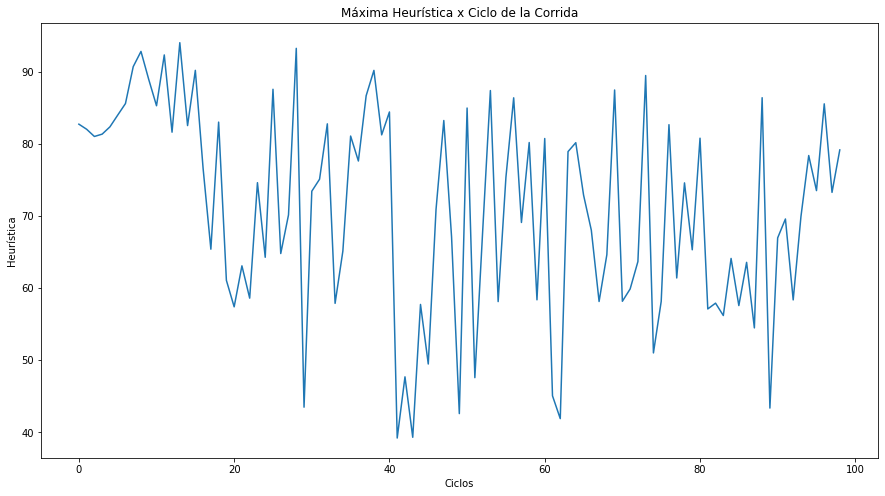

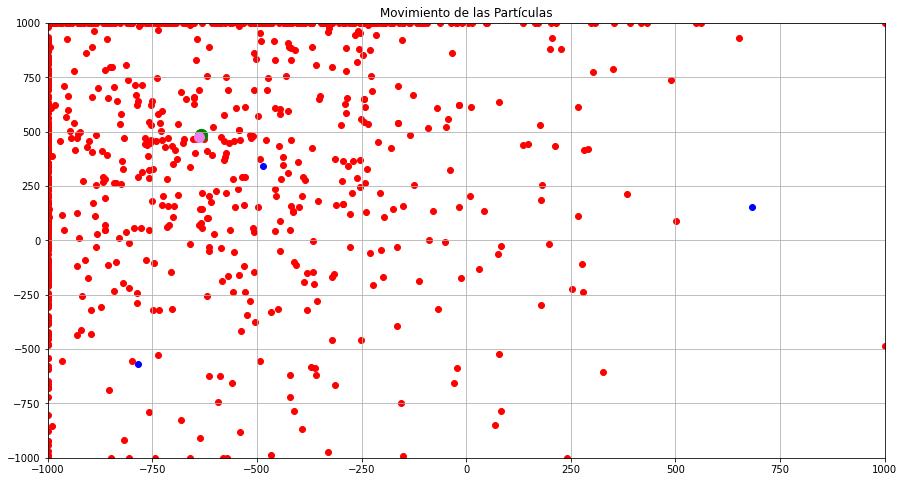

In [6]:
## MOSTRAR GRAFICO DE LA CORRIDA
plt.figure(figsize=(15,8)) 
plt.plot(ciclosMaxAptitud)
plt.title('Máxima Heurística x Ciclo de la Corrida')
plt.xlabel('Ciclos')
plt.ylabel('Heurística')
plt.show()


## MOSTRAR GRAFICO DEL MOVIMIENTO DE LAS PARTICULAS
plt.figure(figsize=(15,8)) 

## --en Rojo: posiciones de las particulas de cada ciclo
for part in ciclosParticulas:
  plt.scatter(part[0], part[1], color='red')

## -- en Azul: Máximos Locales (positivos)
## -- en Cyan: Mínimos Locales (negativos)
## -- en Verde: Máximo Óptimo
for posi, vali in zip(POS_RANDOM_EVALUAR, VAL_RANDOM_EVALUAR):
  if posi == POS_RANDOM_EVALUAR[POS_RANDOM_EVALUAR_OPTIMO]:
      plt.scatter(posi[0], posi[1], color='green', s=150)
  elif vali < 0:
      plt.scatter(posi[0], posi[1], color='cyan')
  else:
      plt.scatter(posi[0], posi[1], color='blue')

## --en Violeta: Mejor posición de las partículas
plt.scatter(mejorPartCorrida.posicion[0], mejorPartCorrida.posicion[1], color='violet', s=100)

plt.title('Movimiento de las Partículas')
plt.xlim(MIN_ESPACIO_BUSQ, MAX_ESPACIO_BUSQ)
plt.ylim(MIN_ESPACIO_BUSQ, MAX_ESPACIO_BUSQ)
plt.grid(True)
plt.show()
